In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [14]:
df = pd.read_csv("weather_burbank_airport.csv")

In [15]:
df.head()

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


Checking for duplicates

In [17]:
sameTimestamp = df[df.duplicated(subset=["timestamp"])]
len(sameTimestamp)

0

After some manual inspection, the dataset contains hourly timestamps for each day. We are probably only interested in those between 6am and 10pm, since before and after that time period, most people are at home. So we extract the necessary ones

In [18]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
dayData = df[(df["timestamp"].dt.hour >= 6) & (df["timestamp"].dt.hour <= 21)]
dayData

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...
29231,Burbank,2020-12-31 19:53:00,17.0,34.0,Fair,985.82,19.0,0.0,17.0
29232,Burbank,2020-12-31 20:53:00,18.0,34.0,Fair,984.50,26.0,0.0,18.0
29233,Burbank,2020-12-31 21:53:00,19.0,34.0,Fair,985.16,19.0,0.0,19.0
29242,Burbank,2021-01-01 06:53:00,11.0,33.0,Fair,987.14,13.0,0.0,11.0


Now we need to check if there are actually enough entries for each day. We can do that by looking at the mean.

In [19]:
tuplesEachDay = dayData.groupby(dayData["timestamp"].dt.date).size()
tuplesEachDay.sort_values()
tuplesEachDay.mean()

18.199817518248175

Expected was a mean of 16, since we removed the entries 00:53, 01:53, 02:53, 03:53, 04:53, 05:53 und 22:53, 23:53. This means there are 8 entries remaining per day, as 24-8=16.

In [20]:
tuplesEachDay

timestamp
2018-01-01    14
2018-01-02    16
2018-01-03    16
2018-01-04    16
2018-01-05    16
              ..
2020-12-28    40
2020-12-29    16
2020-12-30    17
2020-12-31    17
2021-01-01     2
Length: 1096, dtype: int64

After looking at a day like the 2020-12-28 with 40 entries, it seems like there were additional measurements on some days. They seem logical and in the end its just more data, which is usually a good thing. We decide to keep them. It probably leads to more accurate means.

On the other hand, the 2021-01-01 is the last day of the measurements, so they stopped and we only have 2 entries. We decide to keep those.

Now we calculate the mean temperature, mean cloud cover and mean precipitation for each day.

In [21]:
meansPerDay = dayData.groupby(dayData["timestamp"].dt.date).agg({
    "temperature": "mean",
    "cloud_cover": "mean",
    "precipitation": "mean"
}).reset_index()

meansPerDay.rename(columns={"timestamp": "day"}, inplace=True)
meansPerDay.head()

,day,temperature,cloud_cover,precipitation
0,2018-01-01,12.857143,32.142857,0.0
1,2018-01-02,15.062500,28.937500,0.0
2,2018-01-03,16.687500,28.500000,0.0
3,2018-01-04,15.500000,30.250000,0.0
4,2018-01-05,16.500000,31.750000,0.0


We need to round the data to 2 decimals

In [22]:
meansPerDay["temperature"] = meansPerDay["temperature"].apply(lambda x: round(x, 2))
meansPerDay["cloud_cover"] = meansPerDay["cloud_cover"].apply(lambda x: round(x, 2))
meansPerDay["precipitation"] = meansPerDay["precipitation"].apply(lambda x: round(x, 2))
meansPerDay.head()

,day,temperature,cloud_cover,precipitation
0,2018-01-01,12.86,32.14,0.0
1,2018-01-02,15.06,28.94,0.0
2,2018-01-03,16.69,28.50,0.0
3,2018-01-04,15.50,30.25,0.0
4,2018-01-05,16.50,31.75,0.0


In [23]:
meansPerDay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            1096 non-null   object 
 1   temperature    1096 non-null   float64
 2   cloud_cover    1096 non-null   float64
 3   precipitation  1096 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.4+ KB


In [24]:
meansPerDay["day"] = pd.to_datetime(meansPerDay["day"])
meansPerDay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   day            1096 non-null   datetime64[ns]
 1   temperature    1096 non-null   float64       
 2   cloud_cover    1096 non-null   float64       
 3   precipitation  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 34.4 KB


Thats all the data we take from the weather data, as the rest seems unnessesary and to keep the dimensions to a minimum, we decide to only take temperature, cloud cover and precipitation into account.

Now we have clean and easily usable data to map to the rest of the data. We just need to save the meansPerDay as a csv and continue with the mapping in dataPreparation

In [25]:
meansPerDay.to_csv("cleanWeatherData.csv")

For the feature engineering we need the weather data by hour. Since we already have that given, we just work with that.

In [26]:
df.head()

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     29244 non-null  object        
 1   timestamp                29244 non-null  datetime64[ns]
 2   temperature              29219 non-null  float64       
 3   cloud_cover              29224 non-null  float64       
 4   cloud_cover_description  29224 non-null  object        
 5   pressure                 29236 non-null  float64       
 6   windspeed                29158 non-null  float64       
 7   precipitation            29244 non-null  float64       
 8   felt_temperature         29218 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 2.0+ MB


We only keep timestamp, temperature, cloud_cover, pressure, windspeed and precipitation

In [28]:
df = df.drop("city", axis=1)
df = df.drop("cloud_cover_description", axis=1)
df = df.drop("felt_temperature", axis=1)
df.head()

,timestamp,temperature,cloud_cover,pressure,windspeed,precipitation
0,2018-01-01 08:53:00,9.0,33.0,991.75,9.0,0.0
1,2018-01-01 09:53:00,9.0,33.0,992.08,0.0,0.0
2,2018-01-01 10:53:00,9.0,21.0,992.08,0.0,0.0
3,2018-01-01 11:53:00,9.0,29.0,992.08,0.0,0.0
4,2018-01-01 12:53:00,8.0,33.0,992.08,0.0,0.0


Now we check for missing values

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      29244 non-null  datetime64[ns]
 1   temperature    29219 non-null  float64       
 2   cloud_cover    29224 non-null  float64       
 3   pressure       29236 non-null  float64       
 4   windspeed      29158 non-null  float64       
 5   precipitation  29244 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.3 MB


It seems there are some values missing in temperature, pressure and windspeed. Now we also check for missing timestamps

<Axes: >

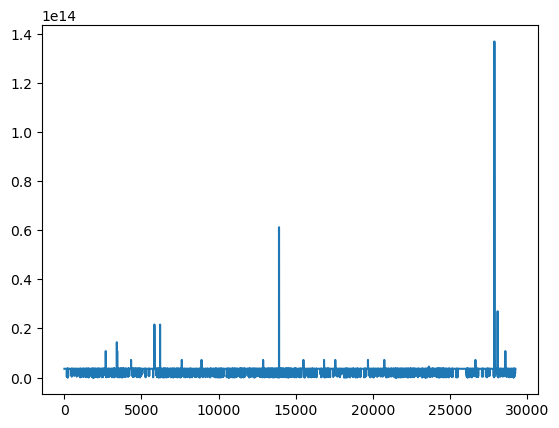

In [30]:
times_gaps = df["timestamp"] - df["timestamp"].shift(1)
times_gaps.plot()

There are some missing values. We will dig deeper

In [31]:
missingTimes = times_gaps[times_gaps > times_gaps.iloc[1]]
missingTimes

2682    0 days 03:00:00
3402    0 days 04:00:00
3425    0 days 03:00:00
4324    0 days 02:00:00
5839    0 days 06:00:00
6206    0 days 06:00:00
7615    0 days 02:00:00
8896    0 days 02:00:00
12888   0 days 02:00:00
13919   0 days 17:00:00
15501   0 days 02:00:00
16839   0 days 02:00:00
17568   0 days 02:00:00
19688   0 days 02:00:00
20745   0 days 02:00:00
23637   0 days 01:15:00
26148   0 days 01:03:00
26656   0 days 02:00:00
27887   1 days 14:00:00
27915   0 days 02:00:00
28096   0 days 07:30:00
28597   0 days 03:00:00
Name: timestamp, dtype: timedelta64[ns]

It seems that there are only minor jumps where one or two timestamps are missing in between. One is medium with 17 hours skipped and one quite large with 1 day and 14 hours skipped.

In [32]:
missingTimes = times_gaps[times_gaps < times_gaps.iloc[1]]
missingTimes

150     0 days 00:43:00
151     0 days 00:05:00
152     0 days 00:12:00
153     0 days 00:37:00
154     0 days 00:23:00
              ...      
29162   0 days 00:53:00
29198   0 days 00:09:00
29199   0 days 00:51:00
29228   0 days 00:33:00
29229   0 days 00:27:00
Name: timestamp, Length: 5213, dtype: timedelta64[ns]

There seem to be a lot of values in between the regular timestamps (those at 53 minutes). After inspecting the data, these values are superflous, since they are basically copys of the regluar timestamps surrounding them.

In [33]:
def removeMinorValues(tdf):
    for index, row in tdf.iterrows():
        if(row["timestamp"].minute != 53):
            tdf.drop(index, inplace=True)
    return tdf

In [34]:
df = removeMinorValues(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26209 entries, 0 to 29243
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      26209 non-null  datetime64[ns]
 1   temperature    26194 non-null  float64       
 2   cloud_cover    26191 non-null  float64       
 3   pressure       26201 non-null  float64       
 4   windspeed      26129 non-null  float64       
 5   precipitation  26209 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.4 MB


Now we need to add the rows for the missing timestamps

In [35]:
def addMissingRows(tdf):
    tdf = tdf.sort_values(by="timestamp").reset_index(drop=True)
    rows = []
    for i in range(len(tdf)-1):
        rows.append(tdf.iloc[i])
        currentTime = tdf.iloc[i]["timestamp"]
        nextTime = tdf.iloc[i+1]["timestamp"]
        while(nextTime-currentTime > pd.Timedelta(hours=1)):
            currentTime+= pd.Timedelta(hours=1)
            rows.append(pd.Series({"timestamp": currentTime, **{col: pd.NA for col in tdf.columns if col != "timestamp"}}))
    rows.append(tdf.iloc[len(tdf)-1])
    newDf = pd.DataFrame(rows)
    newDf = newDf.sort_values(by="timestamp").reset_index(drop=True)
    return newDf

In [36]:
df = addMissingRows(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      26304 non-null  datetime64[ns]
 1   temperature    26194 non-null  object        
 2   cloud_cover    26191 non-null  object        
 3   pressure       26201 non-null  object        
 4   windspeed      26129 non-null  object        
 5   precipitation  26209 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.2+ MB


We need to reconvert to floats when possible

In [37]:
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
df["cloud_cover"] = pd.to_numeric(df["cloud_cover"], errors="coerce")
df["pressure"] = pd.to_numeric(df["pressure"], errors="coerce")
df["windspeed"] = pd.to_numeric(df["windspeed"], errors="coerce")
df["precipitation"] = pd.to_numeric(df["precipitation"], errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      26304 non-null  datetime64[ns]
 1   temperature    26194 non-null  float64       
 2   cloud_cover    26191 non-null  float64       
 3   pressure       26201 non-null  float64       
 4   windspeed      26129 non-null  float64       
 5   precipitation  26209 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.2 MB


For the missing values, we will fill them with the average of the values before and after the missing hour(s).

In [38]:
def addMissingValues(tdf):
    columns = ["temperature", "cloud_cover", "pressure", "windspeed", "precipitation"]
    for s in columns:
        for i in range(len(tdf)-1):
            indexNext = i+1
            if (np.isnan(tdf[s][i])):
                while(np.isnan(tdf[s][indexNext])):
                 indexNext += 1
                newValue = ((tdf[s][i-1] + tdf[s][indexNext])/2).round(2)
                for h in range(i,indexNext):
                    tdf.loc[h, s] = newValue
    return tdf

In [39]:
df = addMissingValues(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      26304 non-null  datetime64[ns]
 1   temperature    26304 non-null  float64       
 2   cloud_cover    26304 non-null  float64       
 3   pressure       26304 non-null  float64       
 4   windspeed      26304 non-null  float64       
 5   precipitation  26304 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.2 MB


In [40]:
df.to_csv("cleanWeatherDataFeatureEngineering.csv", index=False)